In [2]:
import tensorflow as tf # 2.3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist
import time as time

Import les donées 

In [3]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

Traitement les données

In [4]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5 
test_image = (test_image - 127.5)/127.5 

# train_image.shape = ([60000, 28, 28, 1]), train_labels.shape = (60000,)

# Transformation de type 
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données

In [5]:
# Dataset
batchsize = 128
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(batchsize)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(batchsize)

In [6]:
print(test_labels[0])

tf.Tensor(7, shape=(), dtype=int64)


## Construire le modèle MLP maxout et l'entraîner

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_img(model,input_image, input_label, epsilon):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  adv_img = input_image + epsilon*signed_grad
  adv_img = tf.clip_by_value(adv_img, -1, 1)
  return signed_grad

In [8]:
def max_out(inputs, num_units, axis=None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    outputs = tf.reduce_max(tf.reshape(inputs, shape), -1, keepdims=False)
    return outputs

In [21]:
# Build model
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1200)(x)
x = max_out(x, 300, axis=None)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(40)(x)
x = max_out(x, 10, axis=None)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dropout_6 (Dropout)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 1200)              942000    
                                                                 
 tf.reshape_6 (TFOpLambda)   (None, 300, 4)            0         
                                                                 
 tf.math.reduce_max_6 (TFOpL  (None, 300)              0         
 ambda)                                                          
                                                           

## train maxout network without FGSM

In [22]:
optimizer = tf.keras.optimizers.Adam(decay=1e-6)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
#optimizer = tf.optimizers.SGD(learning_rate)
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history = model.fit(dataset,validation_data=test_dataset,epochs=50) 

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.7093 - acc: 0.7831 - val_loss: 0.2350 - val_acc: 0.9315
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 0.3726 - acc: 0.8860 - val_loss: 0.1771 - val_acc: 0.9444
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.3040 - acc: 0.9068 - val_loss: 0.1415 - val_acc: 0.9551
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2652 - acc: 0.9177 - val_loss: 0.1285 - val_acc: 0.9588
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2357 - acc: 0.9258 - val_loss: 0.1119 - val_acc: 0.9650
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2238 - acc: 0.9302 - val_loss: 0.0990 - val_acc: 0.9689
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2067 - acc: 0.9348 - val_loss: 0.0988 - val_acc: 0.9694
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - l

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def loss_with_FGSM(model,input_image, input_label, epsilon=1, alpha=0.5):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = model(input_image)
      loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
    signed_grad = tf.sign(gradient)
    adv_img = input_image + epsilon*signed_grad
    adv_img = tf.clip_by_value(adv_img, -1, 1)
    prediction2 = model(adv_img)
    loss2 = loss_object(input_label, prediction2)
    return alpha*loss + (1-alpha) * loss2

## Train with loss_with_FGSM 

In [13]:
def training_loop(model, epochs, optimizer, learning_rate, loss_fn, train_set, val_images, val_labels, nombre_example=60000, batchsize=128):
	average_time_step = []
	optimizer.lr = learning_rate
	acc_collect = []
	loss_collect = []
	len = int(np.floor(nombre_example / batchsize))
	total_steps = epochs*len
	for epoch in range(epochs):
		if epoch > 20:
			optimizer.lr = learning_rate/10
		if epoch > 40:
			optimizer.lr = learning_rate/100
		start_epoch = time.time()
		step = 0
		for element in dataset:
			step = step+1
			start_step = time.time()
			images  = element[0]
			labels =element[1] 
			with tf.GradientTape() as tape:
				loss_value = loss_with_FGSM(model, images, labels, epsilon=0.5, alpha=0.5)
			grads = tape.gradient(loss_value, model.trainable_weights)
			optimizer.apply_gradients(zip(grads, model.trainable_weights))
			if step == len-1:
				logits_val = model(val_images)
				logits_val = np.argmax(logits_val, axis=-1)
				m = tf.keras.metrics.Accuracy()
				m.update_state(val_labels, logits_val)
				acc_collect.append(m.result().numpy())
				print('epoch = ',epoch,'acc train fin epoch = ',m.result().numpy())
				loss_value_temp = loss_value._copy()
				loss_value_temp = float(loss_value_temp)
				loss_collect.append(loss_value_temp)
				print('loss fin epoch = ',loss_value_temp)
	print()
	return model

In [18]:
# Build model
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1200)(x)
x = max_out(x, 300, axis=None)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(40)(x)
x = max_out(x, 10, axis=None)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 1200)              942000    
                                                                 
 tf.reshape_4 (TFOpLambda)   (None, 300, 4)            0         
                                                                 
 tf.math.reduce_max_4 (TFOpL  (None, 300)              0         
 ambda)                                                          
                                                           

Accuracy value decreased after adding penalty. Computation time is significantly longer (Need correction)

In [19]:
model2 = training_loop(model2, epochs=50, optimizer=optimizer, learning_rate=0.001, loss_fn=loss_func, train_set=dataset, val_images=test_image, val_labels=test_labels, nombre_example=60000, batchsize=128)

epoch =  0 acc train fin epoch =  0.9035
loss fin epoch =  1.218421220779419
epoch =  1 acc train fin epoch =  0.9297
loss fin epoch =  1.104238748550415
epoch =  2 acc train fin epoch =  0.9288
loss fin epoch =  0.8003050684928894
epoch =  3 acc train fin epoch =  0.9561
loss fin epoch =  0.9402778744697571
epoch =  4 acc train fin epoch =  0.953
loss fin epoch =  0.80833500623703
epoch =  5 acc train fin epoch =  0.9481
loss fin epoch =  0.5583819150924683
epoch =  6 acc train fin epoch =  0.9572
loss fin epoch =  0.7690662145614624
epoch =  7 acc train fin epoch =  0.9634
loss fin epoch =  0.7739551067352295
epoch =  8 acc train fin epoch =  0.9616
loss fin epoch =  0.6934546232223511
epoch =  9 acc train fin epoch =  0.9617
loss fin epoch =  0.619145929813385
epoch =  10 acc train fin epoch =  0.9655
loss fin epoch =  0.6887596845626831
epoch =  11 acc train fin epoch =  0.9656
loss fin epoch =  0.6869024634361267
epoch =  12 acc train fin epoch =  0.9698
loss fin epoch =  0.562018

Note : La précission finale avec régularisation FGSM dans notebook est plus petit que celle dans python normal

##Implémenter FGSM(Fast Gradient Sign Method)
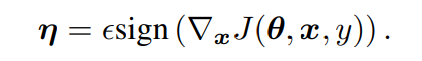

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [24]:
perturbations = create_adversarial_pattern(test_image, test_labels)

Définir une fonction pour plot les images

In [25]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette true par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3)) 
  for i in range(num):  
      plt.subplot(1,num,i+1) 
      plt.imshow(image[i,:,:],cmap='gray') 
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off')
  plt.show()


## Ajouter la perturbations et Tester dans le jeu de test pour model sans régularisation FGSM

epsilons = 0:
313/313 [==============================] - 1s 4ms/step


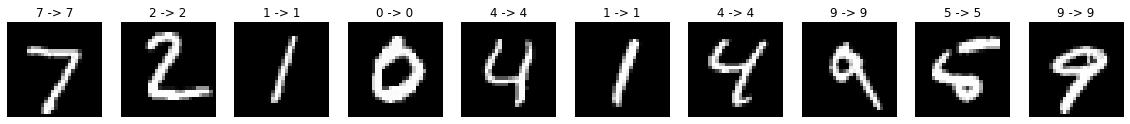

epsilons = 0.05:
313/313 [==============================] - 1s 4ms/step


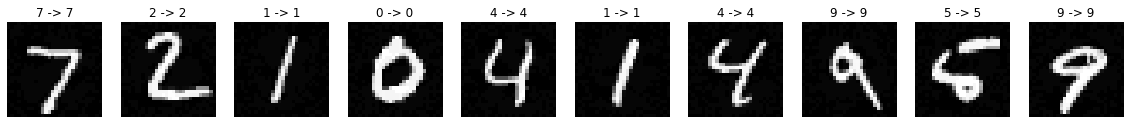

epsilons = 0.1:
313/313 [==============================] - 1s 4ms/step


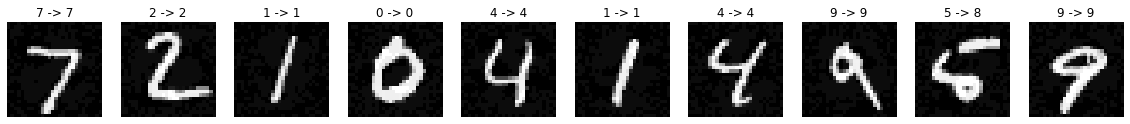

epsilons = 0.15:
313/313 [==============================] - 1s 4ms/step


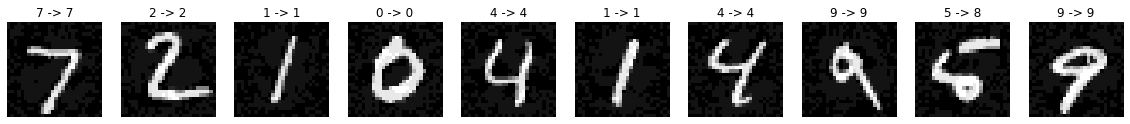

epsilons = 0.2:
313/313 [==============================] - 1s 4ms/step


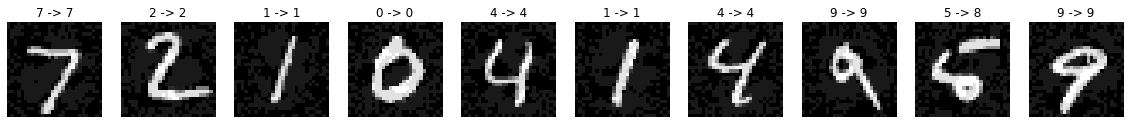

epsilons = 0.25:
313/313 [==============================] - 1s 4ms/step


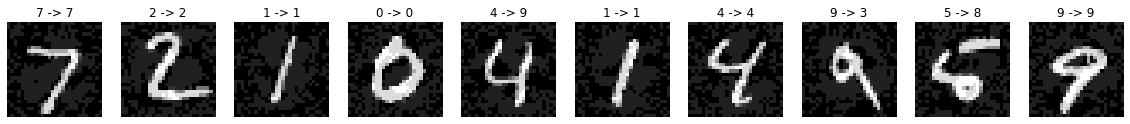

epsilons = 0.3:
313/313 [==============================] - 1s 4ms/step


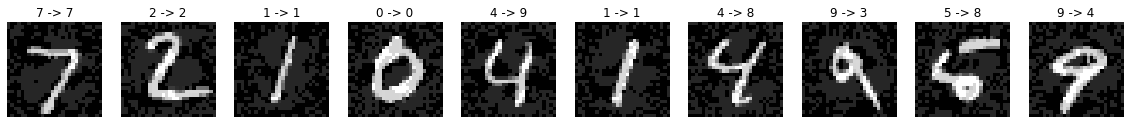

In [26]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

## Ajouter la perturbations et Tester dans le jeu de test pour model avec régularisation FGSM

epsilons = 0:


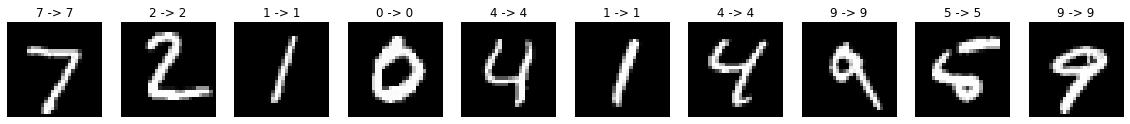

epsilons = 0.05:


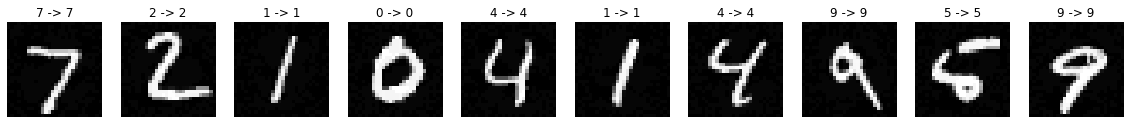

epsilons = 0.1:


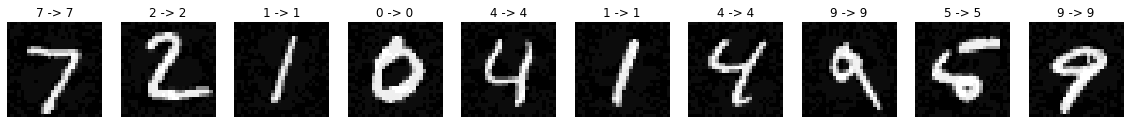

epsilons = 0.15:


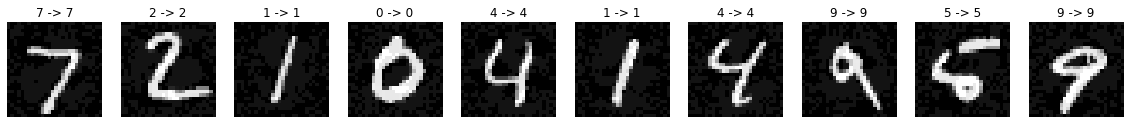

epsilons = 0.2:


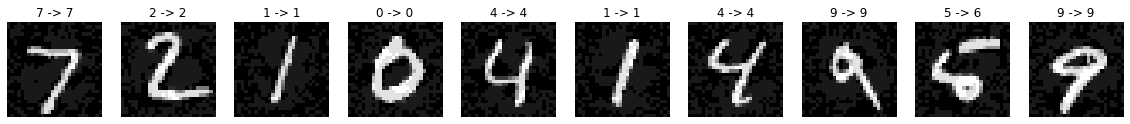

epsilons = 0.25:


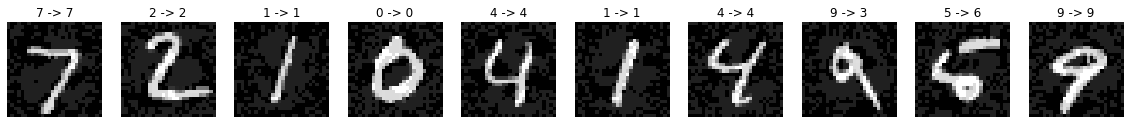

epsilons = 0.3:


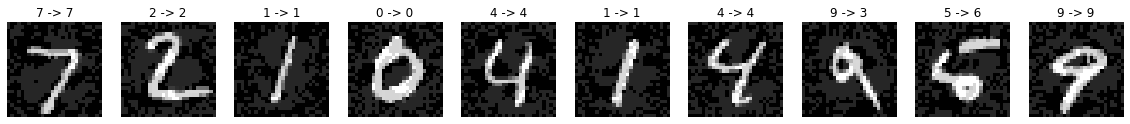

In [29]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model2(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model2(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

## Train with adverseral example (data sugmentation)


In [ ]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #jeux d'entrainement original + jeux d'entrainement perturbe
print(np.shape(train_train_adv))
labels_label_adv = tf.concat([train_labels, train_labels], 0)  

(120000, 28, 28)


In [ ]:
dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(120000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [ ]:
# Build model
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1200)(x)
x = max_out(x, 300, axis=None)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(40)(x)
x = max_out(x, 10, axis=None)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_adv = tf.keras.Model(inputs, outputs)
model_adv.summary()

In [ ]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  adv_image = test_image + eps*perturbations      
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 
  #test_image = tf.clip_by_value(adv_image, -1, 1)
  predict_label = model.predict(adv_image) 
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_predict_label = model_adv.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)
